## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs.

You have several choices here:

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [ ]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()

TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

### Data loading: "Евгений Онегин"


In [2]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = [x.replace('\t\t', '') for x in text]

--2023-12-17 21:02:35--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.004s  

2023-12-17 21:02:36 (57.6 MB/s) - ‘onegin.txt’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
from random import sample
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
out = ''.join(text).lower()

Put all the characters, that you've seen in the text, into variable `tokens`.

In [6]:
tokens = sorted(set(out)) + ['<sos>']
num_tokens = len(tokens)
print(num_tokens)

84


Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [7]:
token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

text_encoded = [token_to_idx[x] for x in out]

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))

cuda device is available


In [124]:
batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>']

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))

In [125]:
class RNN(nn.Module):
    def __init__(self, num_tokens, embed_size, hidden_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.encoder = nn.Embedding(num_tokens, embed_size)
        self.i2h = nn.Linear(embed_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, num_tokens)

    def forward(self, input, hidden):
        input = self.encoder(input)
        combined = torch.cat([input, hidden], dim=1)
        hidden = self.i2h(combined)
        hidden = torch.tanh(hidden)
        output = self.h2o(hidden)
        return output, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size, requires_grad=True).to(device)

In [126]:
def rnn_loop(rnn, batch_ix):
    batch_size, max_length = batch_ix.size()
    hidden = rnn.init_hidden(batch_size)
    logprobs = []

    for inp in batch_ix.transpose(0, 1):
        p, hidden = rnn(inp, hidden)
        logprobs.append(F.log_softmax(p, dim=1))

    return torch.stack(logprobs, dim=1)

In [128]:
embed_size=16
hidden_size=64

loss_func = nn.NLLLoss()
char_rnn = RNN(num_tokens, embed_size, hidden_size).to(device)

lr = 0.001
opt = torch.optim.Adam(char_rnn.parameters(), lr=lr)
history = []

n_epochs = 10000
print_every = 100

In [129]:
def train(rnn, loss_func, n_epochs):
    for i in range(n_epochs):
        batch_ix = torch.tensor(next(generate_chunk()), dtype=torch.int64).to(device)

        logp_seq = rnn_loop(rnn, batch_ix)

        predictions_logp = logp_seq[:, :-1]
        target_tokens = batch_ix[:, 1:]

        loss = loss_func(
            predictions_logp.reshape(-1, num_tokens),
            target_tokens.reshape(-1))
        loss.backward()
        opt.step()
        opt.zero_grad()

        history.append(loss.data.cpu().numpy())
        if (i+1) % print_every == 0:
            clear_output(True)
            plt.plot(history, label='loss')
            plt.legend()
            plt.show()



Plot the loss function (axis X: number of epochs, axis Y: loss function).

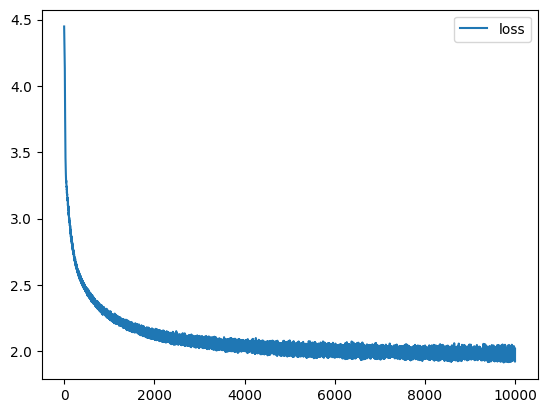

In [130]:
train(char_rnn, loss_func, n_epochs)

In [118]:
def generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''

    if seed_phrase is not None:
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_phrase]
    else:
        x_sequence = [token_to_idx['<sos>']]

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    hidden = char_rnn.init_hidden(1)

    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        _, hidden = char_rnn(x_sequence[:, i], hidden)

    #start generating
    for _ in range(max_length - len(seed_phrase)):
        output, hidden, = char_rnn(x_sequence[:, -1], hidden)
        p_next = F.softmax(output / temperature, dim=-1).data.cpu().numpy()[0]

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return ''.join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]])

In [132]:
# An example of generated text.
print(generate_sample(char_rnn, ' мой дядя самых честных правил', max_length=500, temperature=0.2))

<sos> мой дядя самых честных правилих не то в сердце сердце под на страньца соседе страсть в сердце страньца страньца не под ней своей восполной старинный в слеза своей верный страсной сердце сонадит на привычкой света
под не мой в собрать молодой сонами страсти страсти в толкный следенье
с невого,
и в сердце страсть не привычкой под не восподной своей под не в душа,
в сердце не в порой
не страсти порой в своей под надеждал под не мой в сердце сердце привычкой полновь в сердце приведский соседа
не ст


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

In [133]:
class LSTM(nn.Module):
    def __init__(self, num_tokens, embed_size, hidden_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.embed_size = embed_size

        self.encoder = nn.Embedding(num_tokens, embed_size)
        self.lstm = nn.LSTMCell(embed_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, num_tokens)

    def forward(self, input, hidden):
        input = self.encoder(input)
        hidden = self.lstm(input, hidden)
        output = self.decoder(hidden[0])
        return output, hidden

    def init_hidden(self, batch_size):
        return (torch.zeros(batch_size, self.hidden_size, requires_grad=True).to(device),
                torch.zeros(batch_size, self.hidden_size, requires_grad=True).to(device))

In [134]:
embed_size=16
hidden_size=64

loss_func = nn.NLLLoss()
char_lstm = LSTM(num_tokens, embed_size, hidden_size).to(device)

lr = 0.001
opt = torch.optim.Adam(char_lstm.parameters(), lr=lr)
history = []

n_epochs = 10000
print_every = 100

Plot the loss function of the number of epochs. Does the final loss become better?

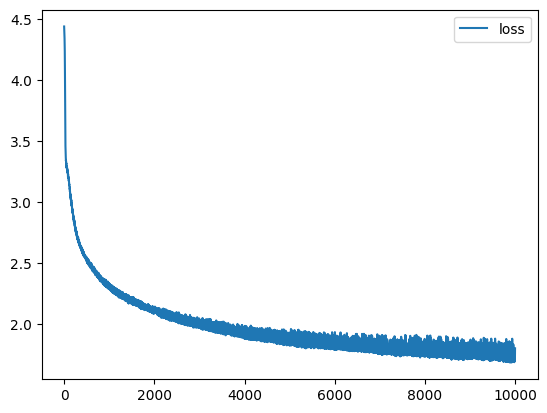

In [135]:
train(char_lstm, loss_func, n_epochs)

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [136]:
print(generate_sample(char_lstm, ' мой дядя самых честных правил', max_length=500, temperature=0.1))

<sos> мой дядя самых честных правилянья,
под не полно в сердце старина
и в сердце старинный страстей.



xxxii

когда бережно привычный старин,
в так не под не под не старина
и в сердце так и полном
и в сон молча в сердце так нет.



xxxi

но в соседе своей ленский,
и в не под не под не полно,
и все долго в суждений старин,
в под не полно приятно поэта
послем и в соседей она,
и в старинный сердце старина
и в соседей он в него нет.



xxxii

когда бы все под не подала,
и в сердце старинный полно,
и в 


In [137]:
print(generate_sample(char_lstm, ' мой дядя самых честных правил', max_length=500, temperature=0.2))

<sos> мой дядя самых честных правилянья,
и в сумяннный старинный стал,
как под не порой слез она след,
и старинный страстей не привыл
с ней на страсти порой страстей.



xxxii

на стало в под не полны сон верно
не старинным страстей полей
под не под не после приважал
и страшно молодых страшной
последной душа своей день
и таня в сон молчали в полны,
и всё на страна пред ней нет.



xxxi

но в сердце старинный страстей.



xxxiii

привычный старинный красавил
с ней не слушал с своей ленский,
и в сон и 


In [138]:
print(generate_sample(char_lstm, ' мой дядя самых честных правил', max_length=500, temperature=0.5))

<sos> мой дядя самых честных правиляньем,
и не много примо и надменьем
и деревесть и не пора,
с ольгою про меня взяков,
не своей мире так и зная
мечтанье модой молкнем,
и все досеностью любил;
но моя приятный милодой,
приемами в том она летой
прости довольно уперь.



xli

и на смезнам жена любил…
оня с нале свои теперь
тебя скорей за сумянндиго
она в очень потом меня,
красавиц на старинны ней.




xl

но том деревне был указать:
не мошут забывалось умел
когда жива молодой их,
за под ней деревне так 


In [139]:
print(generate_sample(char_lstm, ' мой дядя самых честных правил', max_length=500, temperature=1.0))

<sos> мой дядя самых честных правиляньем,
кумяк, и том, тоснядера глядь,
кумить стмери, жарово мном;
и клечам разов раблены,
я следка, хоть я вобезданы:
девят любя драма нет верки,
и летется день оглоноко
на звак сколько между добра.
к найной денина льединули,
правы в поручкий изменовенье,
зимой не спеды бышь свою?
с читать подмечною своей
на меня в после открылоны!
кадит вравья, прежней – n
метех пустоли жизни свет.
томин вым их рас задмелы ей;
два одне! —
такой-тыскивых мир свечка,
куда
доворый дву


In [140]:
print(generate_sample(char_lstm, ' мой дядя самых честных правил', max_length=500, temperature=2.0))

<sos> мой дядя самых честных правили,
оброшкил; мрязякой писакой
устяетск, всезд;
рошая, эты –ур моусац;
сбливныс двов. с:ихка, хоски.
зды накажел
доддогней!) неонала. – дом.
sвод мижплинье лукко.
и этахылась увом.
вляц:, скшузк!
и, мир,
но тофя
длы»e mtyoriчe,.iii?
ибдену!. перперуждымодки:.


mсюдрезе щяд и играенлюд
всёти ей доэа? веждицнценяк;
зпцкесв? иле лепяйце тут.
спескиграяна режзогородпева,
рочию жарк мии силевный кеды!;
оче тол па нопекойнный что,
чест;
сняй?... онни
даткий всих реягкие —


По графикам лосса во время обучения видно, что LSTM показывает себя чуть лучше, чем обычная RNN.

При температурах 0.1, 0.2 в сгенерированных стихах присутвтсует много реальных слов. При этом заметно, что строчки  часто начинаются с одних и тех же слов. При температурах 0.5, 1.0 начала строчек уже более разнообразное. Но уже все больше выдуманных слов, которые однако похожи слова из русского языка. При температуре 2.0 уже почти все слова неправильные, и они все больше похожи на абракадабру. Интересно, что во всех случаях кроме 2.0 в текстах сохраняется ритм.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [141]:
def save_checkpoint(checkpoint_path, model, optimizer):
    # state_dict: a Python dictionary object that:
    # - for a model, maps each layer to its parameter tensor;
    # - for an optimizer, contains info about the optimizer’s states and hyperparameters used.
    state = {
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)

def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

In [142]:
save_checkpoint('./lstm.pth', char_lstm, opt)

model saved to ./lstm.pth


In [146]:
loaded_lstm = LSTM(num_tokens, embed_size, hidden_size).to(device)
loaded_opt = torch.optim.Adam(loaded_lstm.parameters())
load_checkpoint('./lstm.pth', loaded_lstm, loaded_opt)

model loaded from ./lstm.pth


In [147]:
print(generate_sample(loaded_lstm, ' мой дядя самых честных правил', max_length=500, temperature=0.5))

<sos> мой дядя самых честных правилянье льгантей сердца подать,
и страшной может не смела
и слез молодою сказал,
поступит и друг была недостронный,
на стало и в сумянний разделей
и страна на повесным воли,
просмий переводит не годы,
и светить с ней не без месте же ли
староковился я волилась.
в до не принять бродит старинный
с собою сем уж он леской,
не приятный строгих полле
татьяна в семья был предушит,
на слышит не о дворов и нет
не пролит самом на пора,
под слезы подравился вот
подетель пред печал


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a>
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)